# Model Evaluation & Inference: 0.5m Mangrove

Evaluate trained models on the 0.5m mangrove validation set and visualize predictions.

**Contents**:
1. Load pretrained weights
2. Evaluate (Accuracy, IoU, Precision, Recall, F1)
3. Generate confusion matrix
4. Visualize predictions
5. Run inference on new images

**Dataset**: Binary classification (Not Mangrove vs Mangrove), ignore_index=255

## 1. Setup and Configuration

In [4]:
import sys
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATA_ROOT = Path('../data/0_5m')
WEIGHTS_DIR = Path('../weights')
PLOTS_DIR = Path('../plots/0_5m')

# Data files
IMAGES_FILE = DATA_ROOT / '512dataset_images.npy'
LABELS_FILE = DATA_ROOT / '512dataset_labels.npy'

# Model to evaluate
MODEL_NAME = 'segformer'
WEIGHTS_FILE = WEIGHTS_DIR / f'mangrove_{MODEL_NAME}.pth'

BATCH_SIZE = 16
NUM_WORKERS = 0

# Class definitions (binary)
CLASS_NAMES = ['not_mangrove', 'mangrove']
NUM_CLASSES = 1
IGNORE_INDEX = 255

# Colors for visualization
CLASS_COLORS = {
    0: [0.8, 0.8, 0.8],  # Not mangrove - gray
    1: [0.0, 0.7, 0.0],  # Mangrove - green
}

PLOTS_DIR.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")
print(f"Weights: {WEIGHTS_FILE}")
print(f"Classes: {CLASS_NAMES} (ignore={IGNORE_INDEX})")

Device: cuda
Model: segformer
Weights: ..\weights\mangrove_segformer.pth
Classes: ['not_mangrove', 'mangrove'] (ignore=255)


## 2. Dataset Class

In [5]:
class MangroveDataset(Dataset):
    """Dataset for 0.5m mangrove .npy data."""
    
    MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __init__(self, images_path, labels_path, indices=None):
        self.images = np.load(images_path, mmap_mode='r')
        self.labels = np.load(labels_path, mmap_mode='r')
        self.indices = indices if indices is not None else np.arange(len(self.images))
        
        print(f"Loaded {len(self.indices)} samples")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        
        image = self.images[real_idx].copy()
        label = self.labels[real_idx].copy()
        
        # Convert to torch
        image = torch.from_numpy(image).float()
        if image.max() > 1.5:
            image = image / 255.0
        image = (image - self.MEAN) / self.STD
        
        label = torch.from_numpy(label).long()
        if label.dim() == 3:
            label = label.squeeze(0)
        
        return image, label, real_idx


print("Dataset class defined")

Dataset class defined


## 3. Load Model and Weights

In [6]:
# Add project root to path
sys.path.insert(0, '../../')

from models import DeepLab, ResNet_UNet, SegFormer

print("=== Loading Model ===")
print()

# Initialize model
if MODEL_NAME == 'deeplab':
    model = DeepLab(
        num_classes=NUM_CLASSES,
        input_image_size=512,
        backbone='resnet50',
        output_stride=4
    )
elif MODEL_NAME == 'resnet_unet':
    model = ResNet_UNet(num_classes=NUM_CLASSES)
elif MODEL_NAME == 'segformer':
    model = SegFormer(num_classes=NUM_CLASSES)
else:
    raise ValueError(f"Unknown model: {MODEL_NAME}")

# Load weights
if WEIGHTS_FILE.exists():
    state_dict = torch.load(WEIGHTS_FILE, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Loaded weights from: {WEIGHTS_FILE}")
else:
    print(f"WARNING: Weights file not found: {WEIGHTS_FILE}")
    print("Using randomly initialized model")

model = model.to(device)
model.eval()

print(f"\nModel: {MODEL_NAME}")
print(f"Num classes: {NUM_CLASSES} (binary)")

=== Loading Model ===



Loading weights: 100%|██████████| 364/364 [00:00<00:00, 1185.91it/s, Materializing param=encoder.patch_embeddings.3.proj.weight]            
SegformerModel LOAD REPORT from: nvidia/segformer-b2-finetuned-ade-512-512
Key                                           | Status     |  | 
----------------------------------------------+------------+--+-
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | UNEXPECTED |  | 
decode_head.classifier.bias                   | UNEXPECTED |  | 
decode_head.classifier.weight                 | UNEXPECTED |  | 
decode_head.batch_norm.bias                   | UNEXPECTED |  | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | UNEXPECTED |  | 
decode_head.batch_norm.running_var            | UNEXPECTED |  | 
decode_head.batch_norm.num_batches_tracked    | UNEXPECTED |  | 
decode_head.batch_norm.running_mean           | UNEXPECTED |  | 
decode_head.linear_fuse.weight                | UNEXPECTED |  | 
decode_head.batch_norm.weight                 | UNEXPECTED |  | 

Not

Loaded weights from: ..\weights\mangrove_segformer.pth

Model: segformer
Num classes: 1 (binary)


## 4. Load Validation Dataset

In [7]:
print("=== Loading Validation Dataset ===")
print()

# Load validation indices
val_indices_file = DATA_ROOT / 'val_indices.npy'

if val_indices_file.exists():
    val_indices = np.load(val_indices_file)
    print(f"Loaded validation indices from: {val_indices_file.name}")
else:
    # Use last 20% if no split file
    total = len(np.load(IMAGES_FILE, mmap_mode='r'))
    split_idx = int(total * 0.8)
    val_indices = np.arange(split_idx, total)
    print(f"No split file found, using last 20%")

val_dataset = MangroveDataset(IMAGES_FILE, LABELS_FILE, indices=val_indices)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nValidation samples: {len(val_dataset):,}")
print(f"Validation batches: {len(val_loader):,}")

=== Loading Validation Dataset ===

Loaded validation indices from: val_indices.npy
Loaded 115 samples

Validation samples: 115
Validation batches: 8


## 5. Evaluation Metrics Functions

In [8]:
def compute_metrics(pred, target, num_classes, ignore_index=255):
    """
    Compute segmentation metrics, ignoring specified index.
    """
    pred = pred.flatten()
    target = target.flatten()
    
    # Mask out ignore pixels
    valid = target != ignore_index
    pred = pred[valid]
    target = target[valid]
    
    # Pixel accuracy
    pixel_acc = (pred == target).sum() / len(target)
    
    # Per-class metrics
    class_iou = []
    class_precision = []
    class_recall = []
    class_f1 = []
    
    for c in range(num_classes):
        pred_c = pred == c
        target_c = target == c
        
        tp = (pred_c & target_c).sum()
        fp = (pred_c & ~target_c).sum()
        fn = (~pred_c & target_c).sum()
        
        iou = tp / (tp + fp + fn + 1e-10)
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        
        class_iou.append(iou)
        class_precision.append(precision)
        class_recall.append(recall)
        class_f1.append(f1)
    
    return {
        'pixel_accuracy': float(pixel_acc),
        'mean_iou': float(np.mean(class_iou)),
        'class_iou': [float(x) for x in class_iou],
        'class_precision': [float(x) for x in class_precision],
        'class_recall': [float(x) for x in class_recall],
        'class_f1': [float(x) for x in class_f1],
    }


print("Metrics functions defined")

Metrics functions defined


## 6. Run Evaluation

In [9]:
print("=== Running Evaluation ===")
print()

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks, _ in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).squeeze(1).long()  # Threshold at 0.5
        
        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

print(f"\nPredictions shape: {all_preds.shape}")
print(f"Targets shape: {all_targets.shape}")

=== Running Evaluation ===



Evaluating: 100%|██████████| 8/8 [03:04<00:00, 23.05s/it]


Predictions shape: (115, 512, 512)
Targets shape: (115, 512, 512)


In [11]:
# Compute metrics
print("=== Computing Metrics ===")
print()

metrics = compute_metrics(all_preds, all_targets, num_classes=2, ignore_index=IGNORE_INDEX)

print(f"Overall Metrics:")
print(f"  Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
print(f"  Mean IoU:       {metrics['mean_iou']:.4f}")
print()

print(f"Per-Class Metrics:")
print(f"{'Class':<15} {'IoU':>8} {'Precision':>10} {'Recall':>8} {'F1':>8}")
print("-" * 55)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<15} {metrics['class_iou'][i]:>8.4f} {metrics['class_precision'][i]:>10.4f} {metrics['class_recall'][i]:>8.4f} {metrics['class_f1'][i]:>8.4f}")

=== Computing Metrics ===

Overall Metrics:
  Pixel Accuracy: 0.6205
  Mean IoU:       0.3885

Per-Class Metrics:
Class                IoU  Precision   Recall       F1
-------------------------------------------------------
not_mangrove      0.5821     0.6273   0.8900   0.7359
mangrove          0.1948     0.5843   0.2262   0.3261


## 7. Confusion Matrix

=== Generating Confusion Matrix ===



c:\Users\adytc\anaconda3\envs\mangrove\Lib\site-packages\sklearn\metrics\_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


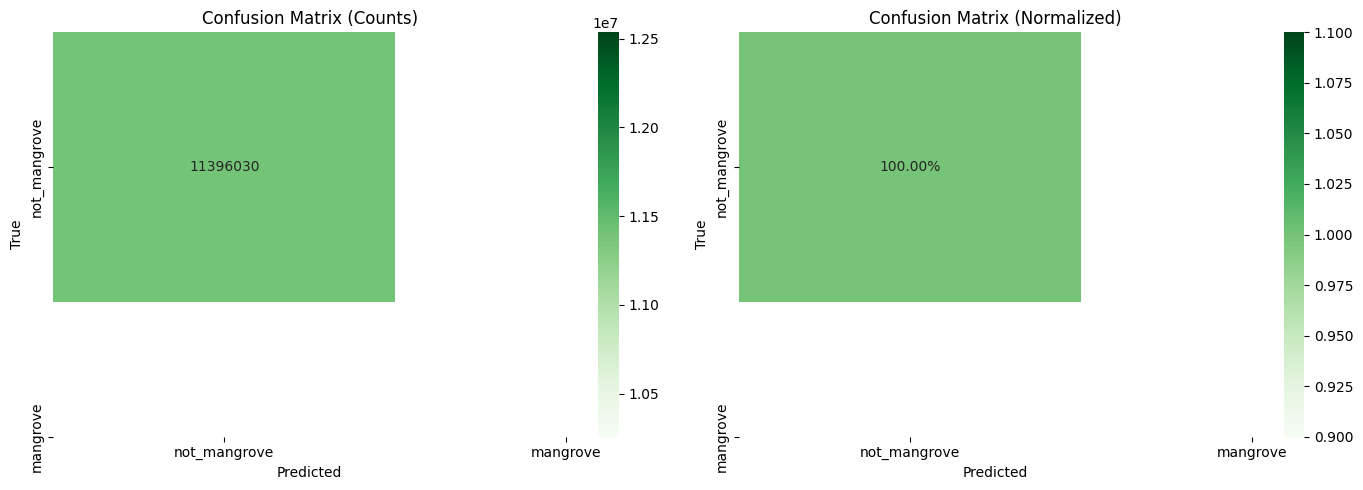

Saved: ..\plots\0_5m\segformer_confusion_matrix.png


In [12]:
print("=== Generating Confusion Matrix ===")
print()

# Flatten and remove ignore pixels
preds_flat = all_preds.flatten()
targets_flat = all_targets.flatten()

valid_mask = targets_flat != IGNORE_INDEX
preds_valid = preds_flat[valid_mask]
targets_valid = targets_flat[valid_mask]

# Compute confusion matrix
cm = confusion_matrix(targets_valid, preds_valid, labels=range(NUM_CLASSES))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / f'{MODEL_NAME}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / f'{MODEL_NAME}_confusion_matrix.png'}")

## 8. Per-Class IoU Bar Chart

=== Plotting Per-Class IoU ===



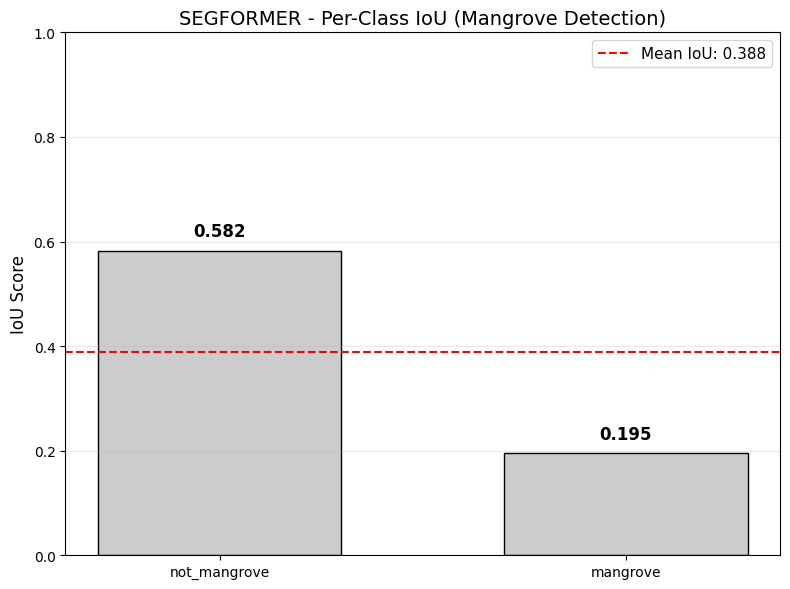

Saved: ..\plots\0_5m\segformer_class_iou.png


In [13]:
print("=== Plotting Per-Class IoU ===")
print()

fig, ax = plt.subplots(figsize=(8, 6))

colors = [CLASS_COLORS[i] for i in range(NUM_CLASSES)]
bars = ax.bar(CLASS_NAMES, metrics['class_iou'], color=colors, edgecolor='black', width=0.6)

for bar, iou in zip(bars, metrics['class_iou']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{iou:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.axhline(y=metrics['mean_iou'], color='red', linestyle='--',
           label=f"Mean IoU: {metrics['mean_iou']:.3f}")

ax.set_ylabel('IoU Score', fontsize=12)
ax.set_title(f'{MODEL_NAME.upper()} - Per-Class IoU (Mangrove Detection)', fontsize=14)
ax.set_ylim(0, 1.0)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / f'{MODEL_NAME}_class_iou.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / f'{MODEL_NAME}_class_iou.png'}")

## 9. Visualize Predictions

In [16]:
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)


def mask_to_rgb(mask, class_colors, ignore_index=255):
    """Convert class mask to RGB image."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3))
    for class_id, color in class_colors.items():
        rgb[mask == class_id] = color
    # Show ignore as white
    rgb[mask == ignore_index] = [1.0, 1.0, 1.0]
    return rgb


def visualize_sample(model, dataset, idx, save_path=None):
    """Visualize a single sample with prediction."""
    model.eval()
    
    img, mask, real_idx = dataset[idx]
    
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = (torch.sigmoid(pred) > 0.5).squeeze().long().cpu().numpy()
    
    img_np = denormalize(img).numpy().transpose(1, 2, 0)
    mask_np = mask.numpy()
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Sample Index: {real_idx}', fontsize=12)
    
    axes[0].imshow(img_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_to_rgb(mask_np, CLASS_COLORS, IGNORE_INDEX))
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    axes[2].imshow(mask_to_rgb(pred_mask, CLASS_COLORS))
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    pred_rgb = mask_to_rgb(pred_mask, CLASS_COLORS)
    overlay = 0.6 * img_np + 0.4 * pred_rgb
    axes[3].imshow(np.clip(overlay, 0, 1))
    axes[3].set_title('Overlay')
    axes[3].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


print("Visualization functions defined")

Visualization functions defined


=== Visualizing Random Samples ===

Sample 1/4


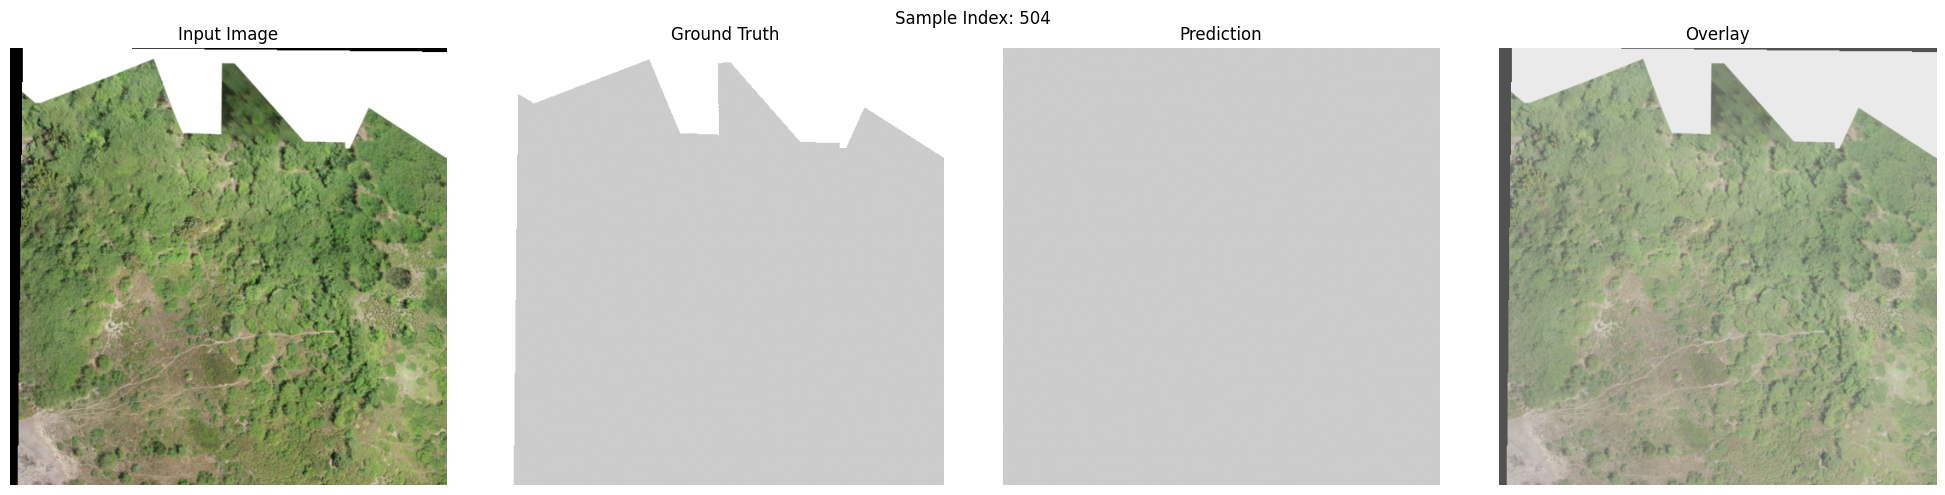

Sample 2/4


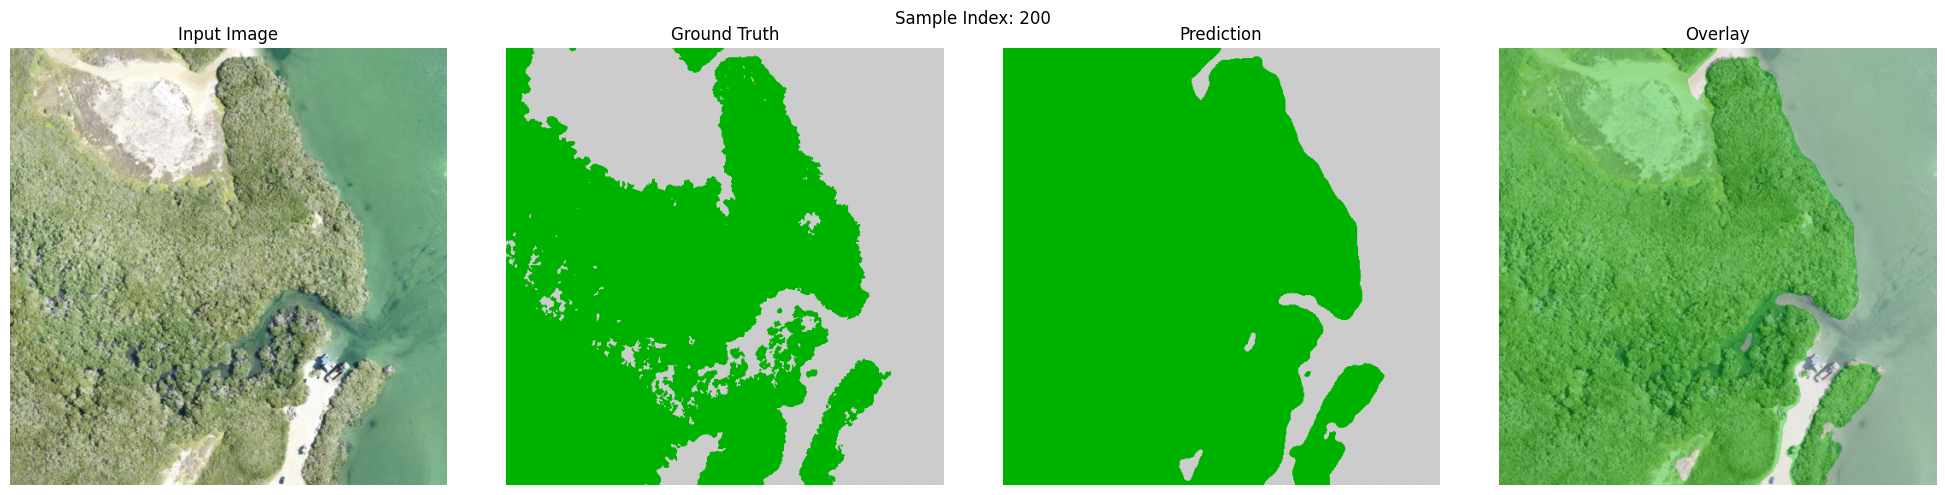

Sample 3/4


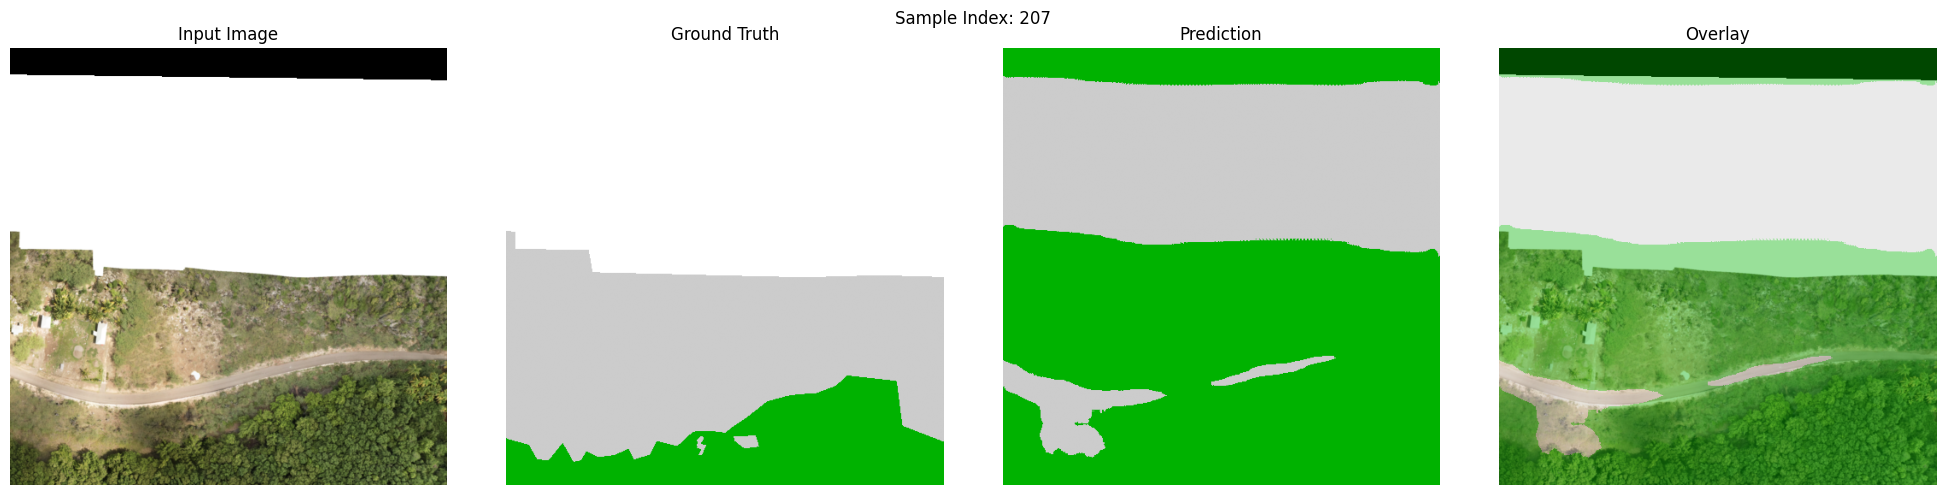

Sample 4/4


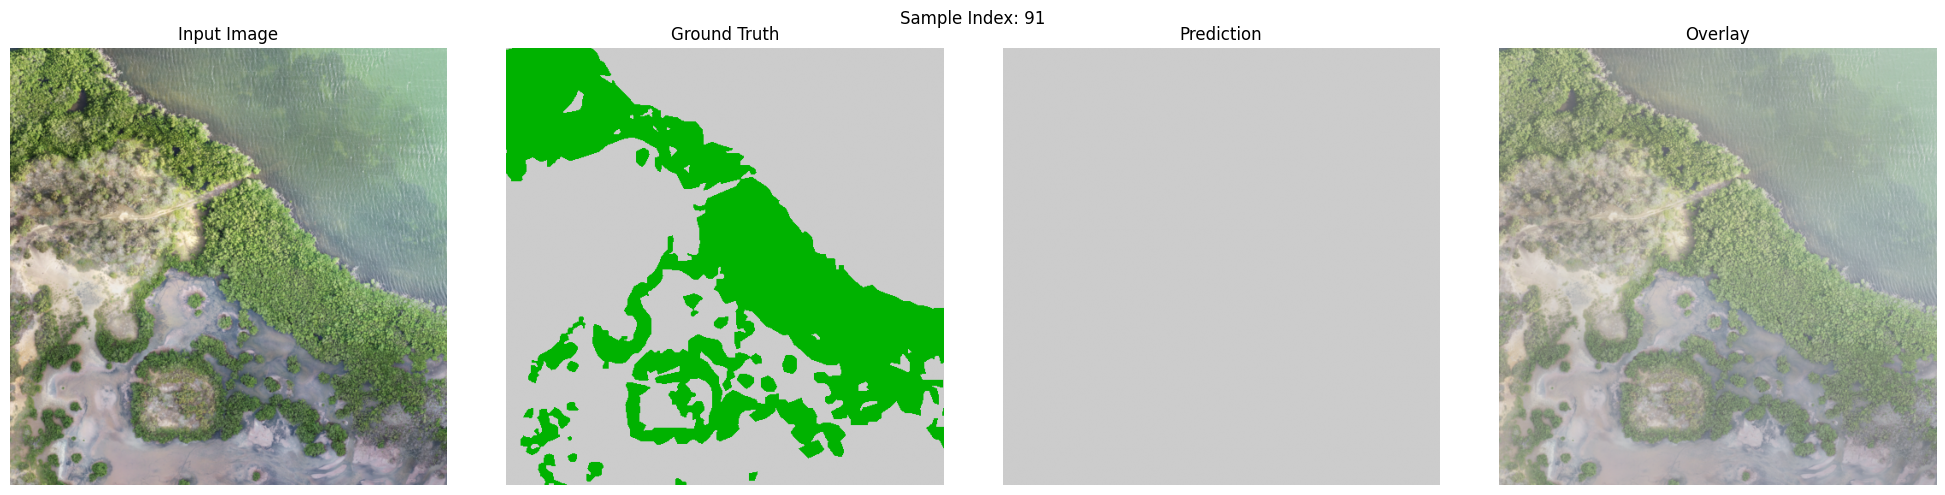

In [17]:
print("=== Visualizing Random Samples ===")
print()

np.random.seed(42)
sample_indices = np.random.choice(len(val_dataset), 4, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"Sample {i+1}/{len(sample_indices)}")
    visualize_sample(model, val_dataset, idx)

## 10. Grid Visualization

=== Creating Grid Visualization ===



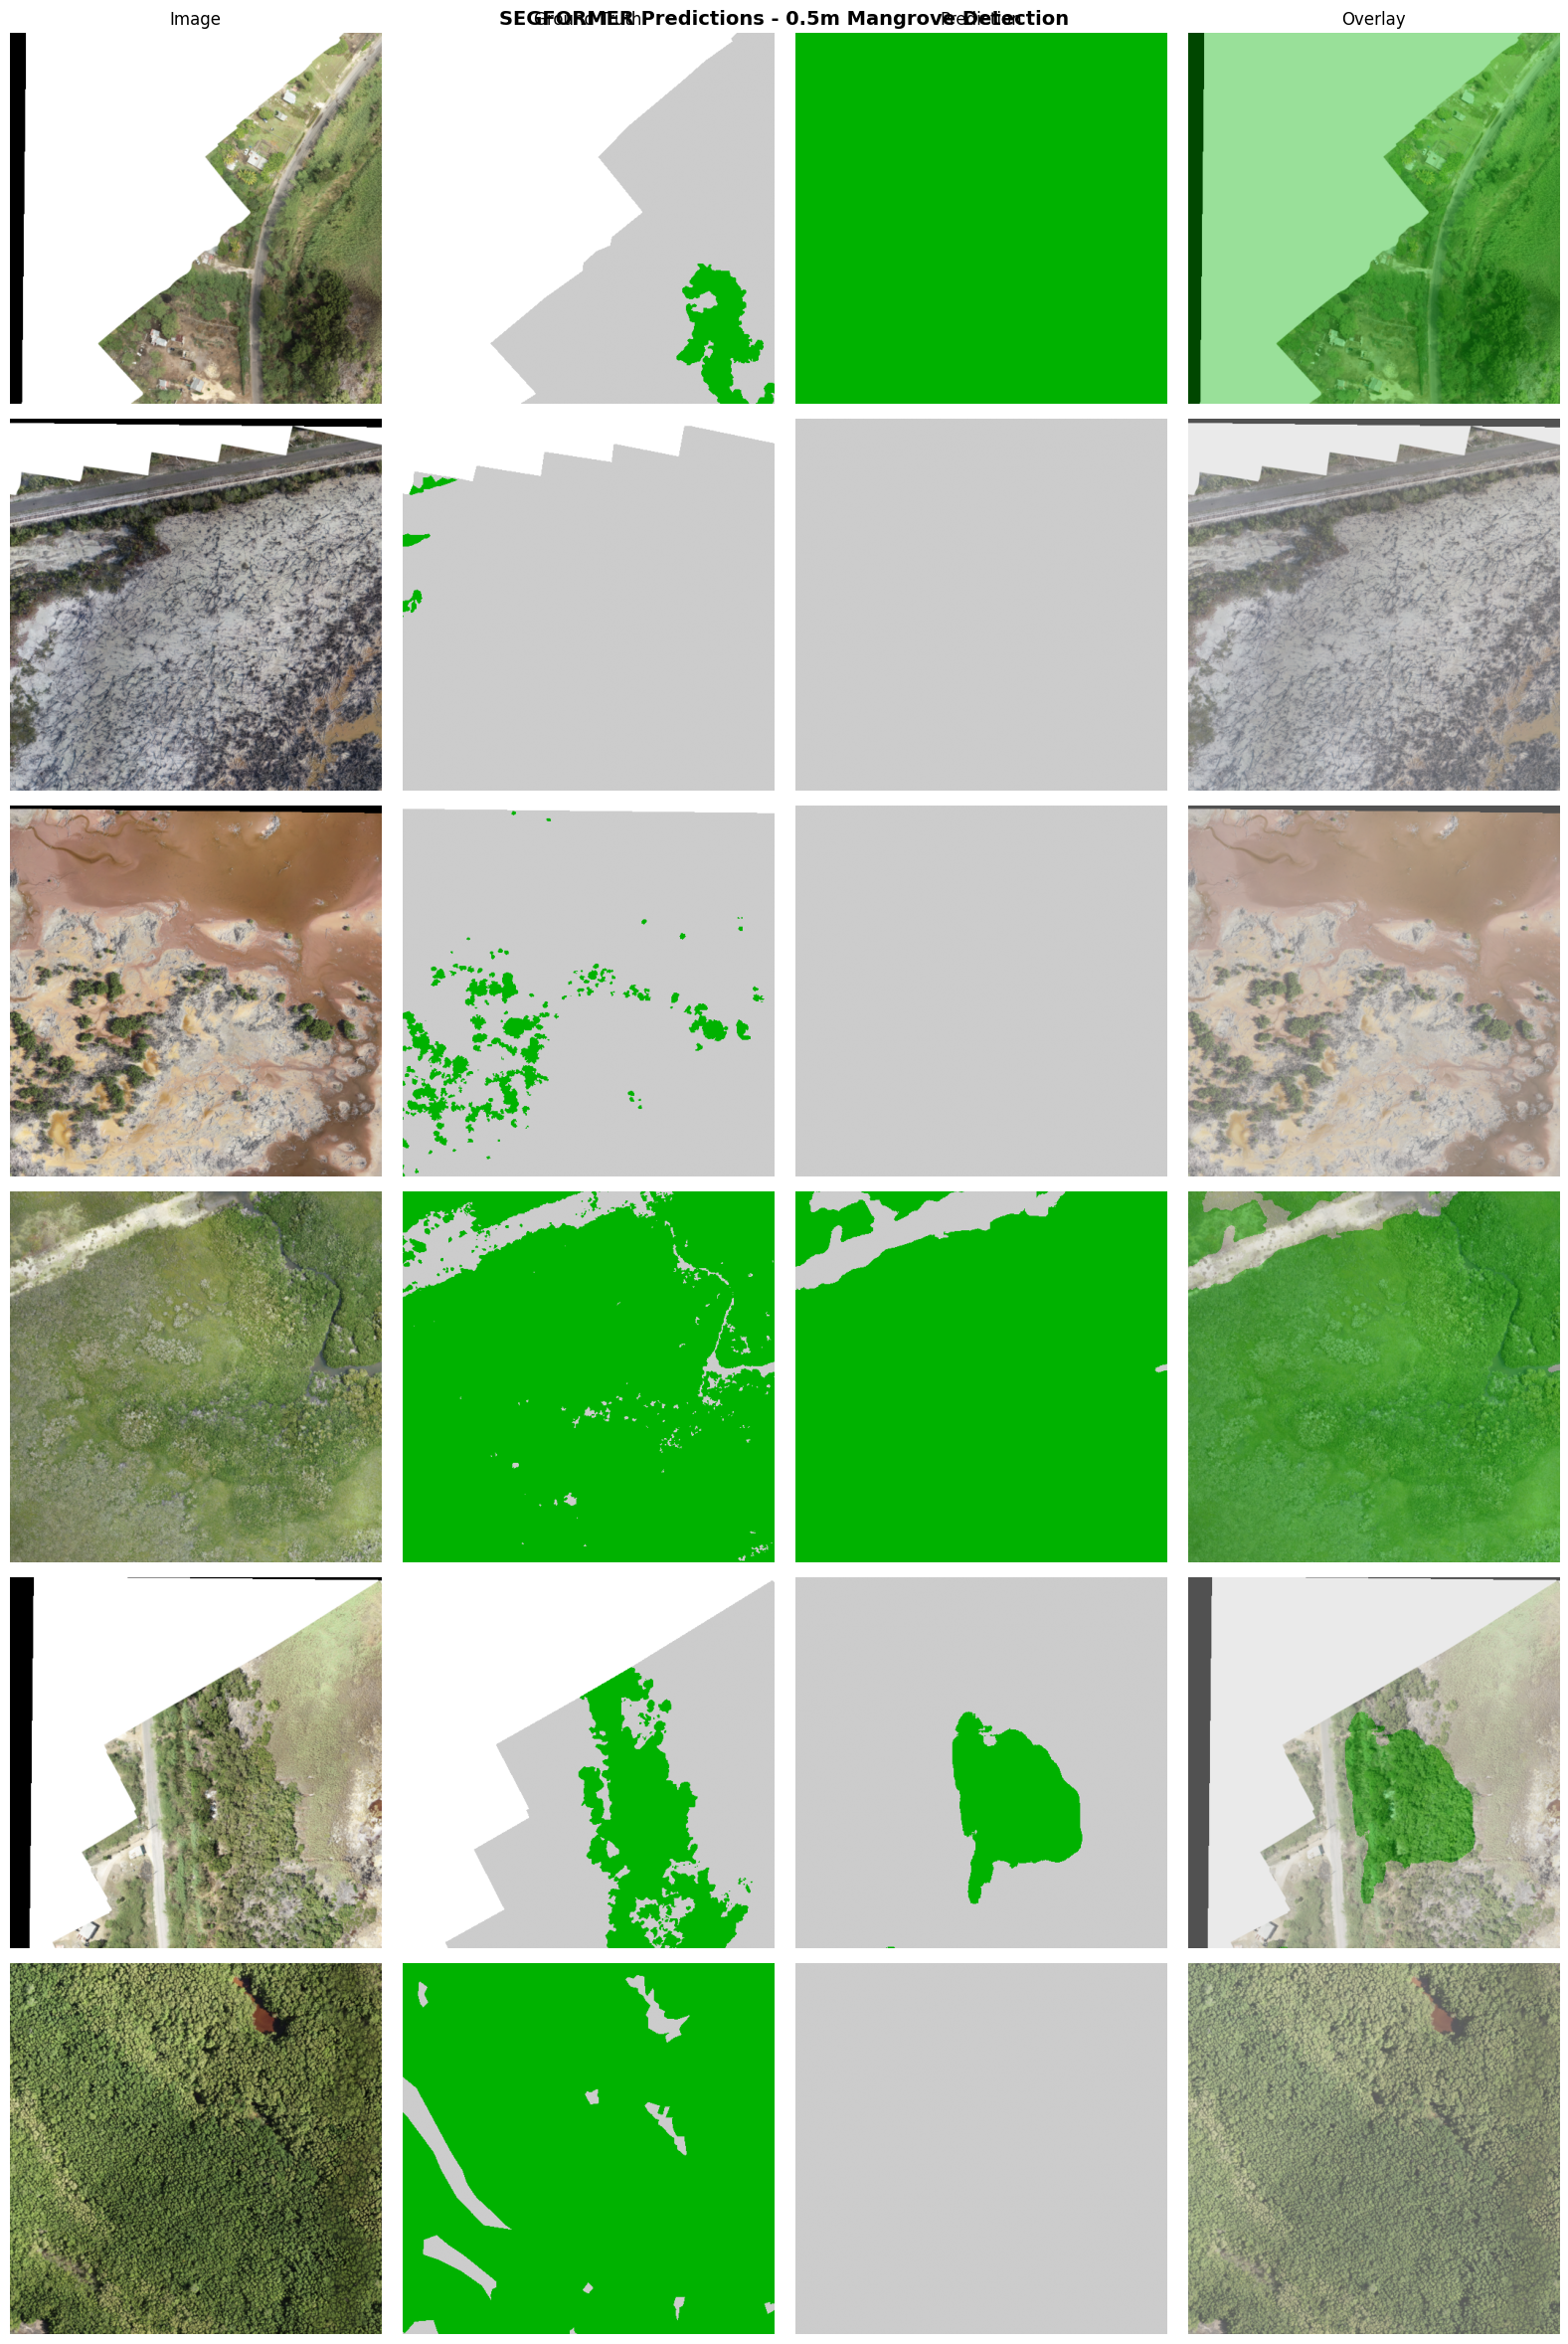

Saved: ..\plots\0_5m\segformer_predictions_grid.png


In [19]:
print("=== Creating Grid Visualization ===")
print()

n_samples = 6
sample_indices = np.random.choice(len(val_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
fig.suptitle(f'{MODEL_NAME.upper()} Predictions - 0.5m Mangrove Detection', fontsize=14, fontweight='bold')

model.eval()
with torch.no_grad():
    for row, idx in enumerate(sample_indices):
        img, mask, _ = val_dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = (torch.sigmoid(pred) > 0.5).squeeze().long().cpu().numpy()
        
        img_np = denormalize(img).numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_title('Image' if row == 0 else '')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(mask_to_rgb(mask_np, CLASS_COLORS, IGNORE_INDEX))
        axes[row, 1].set_title('Ground Truth' if row == 0 else '')
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(mask_to_rgb(pred_mask, CLASS_COLORS))
        axes[row, 2].set_title('Prediction' if row == 0 else '')
        axes[row, 2].axis('off')
        
        overlay = 0.6 * img_np + 0.4 * mask_to_rgb(pred_mask, CLASS_COLORS)
        axes[row, 3].imshow(np.clip(overlay, 0, 1))
        axes[row, 3].set_title('Overlay' if row == 0 else '')
        axes[row, 3].axis('off')

plt.tight_layout()
plt.savefig(PLOTS_DIR / f'{MODEL_NAME}_predictions_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {PLOTS_DIR / f'{MODEL_NAME}_predictions_grid.png'}")

## 11. Inference on New Image

In [ ]:
def run_inference(model, image_path, save_path=None):
    """
    Run inference on a single image file.
    """
    model.eval()
    
    image = np.array(Image.open(image_path))
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]
    
    img_display = image.copy()
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = image.astype(np.float32) / 255.0
    image = (image - mean) / std
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
    
    # Calculate mangrove percentage
    mangrove_pct = (pred_mask == 1).sum() / pred_mask.size * 100
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Inference: {Path(image_path).name} | Mangrove: {mangrove_pct:.1f}%', fontsize=12)
    
    axes[0].imshow(img_display)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_to_rgb(pred_mask, CLASS_COLORS))
    axes[1].set_title('Prediction')
    axes[1].axis('off')
    
    overlay = 0.6 * (img_display / 255.0) + 0.4 * mask_to_rgb(pred_mask, CLASS_COLORS)
    axes[2].imshow(np.clip(overlay, 0, 1))
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    
    return pred_mask, mangrove_pct


print("Inference function defined")
print()
print("Usage:")
print("  pred_mask, mangrove_pct = run_inference(model, 'path/to/image.jpg')")

## 12. Save Evaluation Results

In [ ]:
print("=== Saving Evaluation Results ===")
print()

results = {
    'model_name': MODEL_NAME,
    'weights_file': str(WEIGHTS_FILE),
    'num_val_samples': len(val_dataset),
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'ignore_index': IGNORE_INDEX,
    'metrics': metrics
}

results_file = PLOTS_DIR / f'{MODEL_NAME}_evaluation_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved: {results_file}")
print("\nAll outputs saved to:", PLOTS_DIR)

## 13. Summary

In [ ]:
print("=" * 60)
print("Evaluation Summary")
print("=" * 60)
print()
print(f"Model: {MODEL_NAME}")
print(f"Dataset: 0.5m Mangrove (Binary)")
print(f"Samples: {len(val_dataset):,}")
print()
print(f"Results:")
print(f"  Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
print(f"  Mean IoU:       {metrics['mean_iou']:.4f}")
print()
print(f"Per-Class IoU:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {metrics['class_iou'][i]:.4f}")
print()
print(f"Saved outputs:")
print(f"  - {MODEL_NAME}_confusion_matrix.png")
print(f"  - {MODEL_NAME}_class_iou.png")
print(f"  - {MODEL_NAME}_predictions_grid.png")
print(f"  - {MODEL_NAME}_evaluation_results.json")